# <font size="8" color='#0084C6'>**Capstone Project**</font>

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt


import time
import datetime

import requests
import json 


import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize import RegexpTokenizer
from word2number import w2n
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

## Modelling from gensim - core package for topic modelling
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


## Check performance of our model
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models, similarities


## Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from imp import reload
import multiprocessing

from wordcloud import WordCloud
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

C:\Users\kathl\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


<br><br>
# <font color='#0084C6'>**Sourcing the Data**</font>

In [ ]:
url = 'http://content.guardianapis.com/search'

params = {'type': 'article', 'section': 'politics', 'order-by': 'newest', 'page-size': '100',
        'page':'1', 'from-date':'2011-11-09','to-date':'2022-11-09',
       }

headers = {"api-key": '6136ae4c-91ac-4cbe-9bb5-1e44441683aa'}

req = requests.request("GET", url, headers=headers, params=params)
src = req.text
sections = json.loads(src)

In [ ]:
g_articles = {}
params['page'] = 1

In [ ]:
while True:

    time.sleep(1)
    

    response = requests.request("GET", url, headers=headers, params=params) 
    results = json.loads(response.text.encode())
    if response.status_code == 200:
        print(f'Done for page number => {params["page"]}')

        if not g_articles:
            g_articles = results
        else:
            g_articles['response']['results'].extend(results['response']['results'])

        params['page'] += 1
        if response.status_code != 200:
            print("All articles have been extracted")
            break
        else:
            print(f'Proceed extracting page number => {params["page"]}')
    else:
        print(f'ERROR: API call failed for page number => {params["page"]}')
        break

print(f'Number of extracted articles => {str(len(g_articles))}')

In [ ]:
len(g_articles['response']['results'])

38000

In [ ]:
g_articles.keys()

dict_keys(['response'])

In [ ]:
g_articles['response']['results'][0]

{'id': 'politics/2022/nov/09/sunak-faces-scrutiny-over-whether-he-knew-of-gavin-williamson-bully-claims',
 'type': 'article',
 'sectionId': 'politics',
 'sectionName': 'Politics',
 'webPublicationDate': '2022-11-09T23:06:40Z',
 'webTitle': 'Sunak faces scrutiny over whether he knew of Gavin Williamson bully claims',
 'webUrl': 'https://www.theguardian.com/politics/2022/nov/09/sunak-faces-scrutiny-over-whether-he-knew-of-gavin-williamson-bully-claims',
 'apiUrl': 'https://content.guardianapis.com/politics/2022/nov/09/sunak-faces-scrutiny-over-whether-he-knew-of-gavin-williamson-bully-claims',
 'isHosted': False,
 'pillarId': 'pillar/news',
 'pillarName': 'News'}

In [ ]:
title, section, published_date, api_id, url, body = ([] for i in range(6))

In [ ]:
for i in range(len(g_articles['response']['results'])):
    title.append(g_articles['response']['results'][i]['webTitle'])
    section.append(g_articles['response']['results'][i]['sectionId'])
    published_date.append(g_articles['response']['results'][i]['webPublicationDate'])
    api_id.append(g_articles['response']['results'][i]['id'])
    url.append(g_articles['response']['results'][i]['webUrl'])

In [ ]:
base_url = "https://content.guardianapis.com/search?"

for i_d in api_id:
    search_string = "ids=%s&api-key=6136ae4c-91ac-4cbe-9bb5-1e44441683aa&show-fields=headline,body&show-tags=keyword" %api_id

    url = base_url + search_string
    req = requests.get(url) 
    src = req.text
    sections = json.loads(src)['response']    
    api_id.append(sections['results'][0]['fields']['body'])

In [ ]:
df_import = pd.DataFrame(list(zip(title, section, published_date, api_id, url )))

In [ ]:
df = df_import.copy()

In [ ]:
df.to_csv('guardian_data')

<br><br>

# <font color='#0084C6'>**Inital Cleaning**</font>

In [2]:
df = pd.read_csv('guardian_data')

In [3]:
df.shape

(38000, 6)

In [4]:
df.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4'], dtype='object')

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
df.head(1)

,Unnamed: 0,0,1,2,3,4
0,0,Sunak faces scrutiny over whether he knew of Gavin Williamson bully claims,politics,2022-11-09T23:06:40Z,politics/2022/nov/09/sunak-faces-scrutiny-over-whether-he-knew-of-gavin-williamson-bully-claims,https://www.theguardian.com/politics/2022/nov/09/sunak-faces-scrutiny-over-whether-he-knew-of-gavin-williamson-bully-claims


In [7]:
df.drop(columns='Unnamed: 0', inplace = True)
df.columns = ['headline', 'section','date', 'id', 'weburl']

In [8]:
df.columns

Index(['headline', 'section', 'date', 'id', 'weburl'], dtype='object')

In [9]:
df.head()

,headline,section,date,id,weburl
0,Sunak faces scrutiny over whether he knew of Gavin Williamson bully claims,politics,2022-11-09T23:06:40Z,politics/2022/nov/09/sunak-faces-scrutiny-over-whether-he-knew-of-gavin-williamson-bully-claims,https://www.theguardian.com/politics/2022/nov/09/sunak-faces-scrutiny-over-whether-he-knew-of-gavin-williamson-bully-claims
1,Sunak sharpens knives of his detractors with handling of Williamson scandal,politics,2022-11-09T19:54:37Z,politics/2022/nov/09/sunak-sharpens-knives-of-his-detractors-with-handling-of-williamson-scandal,https://www.theguardian.com/politics/2022/nov/09/sunak-sharpens-knives-of-his-detractors-with-handling-of-williamson-scandal
2,Jeremy Hunt expected to increase number of Britons paying top tax rate,politics,2022-11-09T19:42:29Z,politics/2022/nov/09/jeremy-hunt-expected-increase-number-britons-paying-top-tax-rate,https://www.theguardian.com/politics/2022/nov/09/jeremy-hunt-expected-increase-number-britons-paying-top-tax-rate
3,Rishi Sunak the vanishing man zones out in PMQs pasting | John Crace,politics,2022-11-09T19:28:24Z,politics/2022/nov/09/rishi-sunak-the-vanishing-man-zones-out-in-pmqs-pasting,https://www.theguardian.com/politics/2022/nov/09/rishi-sunak-the-vanishing-man-zones-out-in-pmqs-pasting
4,If only more MPs had done humdrum jobs | Brief letters,politics,2022-11-09T16:55:00Z,politics/2022/nov/09/if-only-more-mps-had-done-humdrum-jobs,https://www.theguardian.com/politics/2022/nov/09/if-only-more-mps-had-done-humdrum-jobs


In [10]:
df.dtypes

headline    object
section     object
date        object
id          object
weburl      object
dtype: object

In [11]:
df.id.nunique()  ## no duplicate articles

38000

In [12]:
df.index.is_unique ## no duplicate indexes

True

In [13]:
df.isna().sum()  ## Very clean API

headline    0
section     0
date        0
id          0
weburl      0
dtype: int64

In [14]:
df.drop(columns=['weburl', 'section', 'id'], inplace = True)

In [15]:
df[['date', 'time']] = df['date'].str.split('T', expand = True)

In [16]:
df.drop(columns='time', inplace = True)

In [17]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = pd.DatetimeIndex(df['date']).year

In [18]:
df.date.nunique()  ##3699 days of articles

3699

In [19]:
## 2012 only from december onwards, does not provide best representation of data
df = df.drop(df[df.year == 2012].index)

In [20]:
df.year.nunique()

10

In [21]:
df['headline_length'] = df['headline'].str.len()
df['headline_length'].describe()

count    36926.000000
mean        64.473406
std         11.477557
min         15.000000
25%         59.000000
50%         65.000000
75%         71.000000
max        172.000000
Name: headline_length, dtype: float64

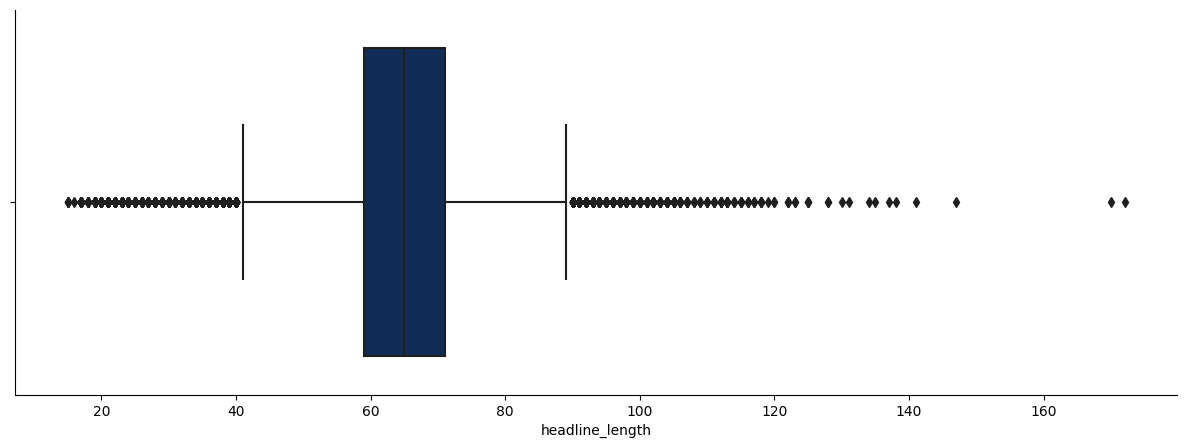

In [22]:
plt.figure(figsize = [15,5])
sns.boxplot(data=df, x='headline_length', color='#052962')
sns.despine()
plt.show()

In [23]:
df.drop(df[df['headline_length'] > 140].index, inplace = True)

In [24]:
df['headline_word_count'] = df['headline'].str.split().apply(len)
df['headline_word_count'].describe()

count    36922.000000
mean        10.541141
std          2.312893
min          2.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         23.000000
Name: headline_word_count, dtype: float64

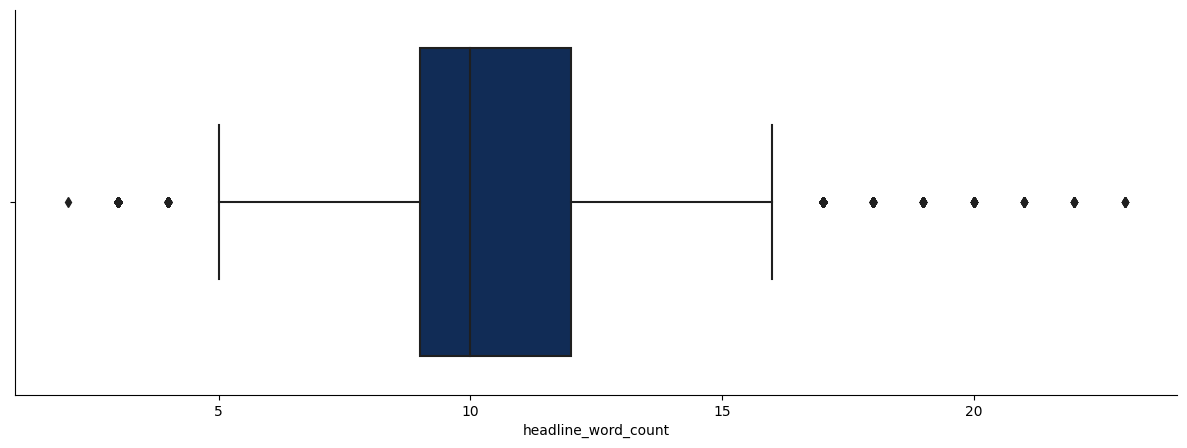

In [25]:
plt.figure(figsize = [15,5])
sns.boxplot(data=df, x='headline_word_count', color='#052962')
sns.despine()
plt.show()

In [26]:
df.drop(df[df['headline_word_count'] > 20].index, inplace = True)

In [27]:
df.drop(columns=['headline_length', 'headline_word_count'], inplace = True)

<br><br>

# <font color='#0084C6'>**Headline Text Cleaning**</font>

**Examples of why I took the required cleaning measures** ?

In [28]:
def clean(txt):
    txt = re.sub(r"\|[^|]*", "", txt)
    return txt
df['headline'] = df['headline'].apply(clean)

In [29]:
df['headline'] = df['headline'].str.lower()

In [30]:
## RegEx to remove possessive characters
replacement_patterns = [
  (r"’s", ''),
  (r"'s", '')]

def remove_possessive(txt): 
    '''Function to expand contractions'''
    for (pattern, repl) in replacement_patterns:
        txt =  " ".join(re.sub(pattern, repl, txt).split())
    return txt

df['headline'] = df['headline'].apply(remove_possessive)

In [31]:
## remove articles about obituaries
pattern = re.compile('obituary|politics live|hugh muir|letters:|#|[\u00C0-\u017F]|best comments today')  #|\|[^|]*
df.drop(df[df['headline'].str.contains(pattern)].index, inplace=True)

In [32]:
pattern = re.compile(r"\b[A-Za-z]*'[A-Za-z]*\b")
len(df[df['headline'].str.contains(pattern)])   ## 628 contractions

619

In [33]:
## RegEx to expand contractions 
replacement_patterns = [
  (r'won\'t', 'will not'),
  (r'can\'t', 'cannot'),
  (r'i\'m', 'i am'),
  (r'ain\'t', 'is not'),
  (r'(\w+)\'ll', '\g<1> will'),
  (r'(\w+)n\'t', '\g<1> not'),
  (r'(\w+)\'ve', '\g<1> have'),
  (r'(\w+)\'re', '\g<1> are'),
  (r'(\w+)\'d', '\g<1> would')
]

def expand_contractions(txt): 
    '''Function to expand contractions'''
    for (pattern, repl) in replacement_patterns:
        txt =  " ".join(re.sub(pattern, repl, txt).split())
    return txt

df['headline'] = df['headline'].apply(expand_contractions)

In [34]:
## remove the o'xxxx to just xxxx
df["headline"] = df["headline"].apply(lambda x: re.sub(r"o'([a-zA-Z])", r"\1", x))

In [35]:
df.shape[0]

35732

In [36]:
name_patterns = [
    (r'jacob rees mogg', 'jacobreesmogg'),
    (r'jacob rees-mogg', 'jacobreesmogg'),
    (r'nick clegg', 'nickclegg'),
    (r'lib dem', 'libdems'),
    (r'imran ahmad khan', 'imranahmadkhan'),
    (r'iain duncan smith', 'iainduncansmith'),
    (r'vince cable', 'vincecable'),
    (r'margaret thatcher', 'margaretthatcher'),
    (r'nicola sturgeon', 'nicolasturgeon'),
    (r'george osborne','georgeosborne'),
    (r'ed miliband', 'edmiliband'),
    (r'scottish independence', 'scottishindependence'),
    (r'tony|blair', 'tonyblair'),
    (r'gordon brown|gordon|brown','gordonbrown'),
    (r'nigel farage', 'nigelfarage'),
    (r'theresa may', 'theresamay'),
    (r'northern ireland', 'northernireland'),
    (r'sadiq khan', 'sadiqkhan'),
    (r'dominic cummings', 'dominiccummings'),
    (r'ed balls', 'edballs'),
    (r'alex salmond', 'alexsalmond'),
    (r'brexit weekly meetings', 'brexit')
]

def replace_names(txt): 
    for (pattern, repl) in name_patterns:
        txt =  " ".join(re.sub(pattern, repl, txt).split())
    return txt

df['headline'] = df['headline'].apply(replace_names)


In [40]:
stpwrd = stopwords.words('english')
stpwrd.extend(['says', 'suggest','revealed', 'diary'])
stpwrd.extend(['', '…','...', '--','‘','’'])
stpwrd.extend([x for x in string.punctuation])
stpwrd.remove('not')

In [41]:
## Snowball Stemmer
s_stemmer = SnowballStemmer(language='english')

In [42]:
def clean_tokens(headline):
    ''' Final cleans, removing meaningless characters, convert num to str etc. '''

    clean_list = []
    for word in headline:
        try:
            word = str(w2n.word_to_num(word))
        except:
            word = word
        clean_list.append(word)

    clean_list = [word for word in clean_list if word not in stpwrd]
    #clean_list = [s_stemmer.stem(word) for word in clean_list]

    ''' unlisting the final answer '''
    clean_list = " ".join(clean_list)

    return clean_list

In [43]:
## Prep our data
def prep_data(headline):

    ''' Function to prep the data '''
    headline = headline.lower()
    ## Part 2 - Tokenize
    headline = RegexpTokenizer(r'\w+').tokenize(headline)

    ## Part 3 - Clean tokens
    headline = clean_tokens(headline)

    return headline 

In [44]:
df['headline_clean'] = df['headline'].apply(prep_data)

In [45]:
df.head(10)

,headline,date,year,headline_clean
0,sunak faces scrutiny over whether he knew of gavin williamson bully claims,2022-11-09,2022,sunak faces scrutiny whether knew gavin williamson bully claims
1,sunak sharpens knives of his detractors with handling of williamson scandal,2022-11-09,2022,sunak sharpens knives detractors handling williamson scandal
2,jeremy hunt expected to increase number of britons paying top tax rate,2022-11-09,2022,jeremy hunt expected increase number britons paying top tax rate
3,rishi sunak the vanishing man zones out in pmqs pasting,2022-11-09,2022,rishi sunak vanishing man zones pmqs pasting
4,if only more mps had done humdrum jobs,2022-11-09,2022,mps done humdrum jobs
6,"rishi sunak too weak to stand up to ‘cartoon bully’ williamson, says starmer",2022-11-09,2022,rishi sunak weak stand cartoon bully williamson starmer
7,matt hancock covered with bugs and sludge in i’m a celebrity preview,2022-11-09,2022,matt hancock covered bugs sludge celebrity preview
8,"sunak was unaware of ‘any specific allegations’ about williamson, says ally",2022-11-09,2022,sunak unaware specific allegations williamson ally
9,"father of modern election science, sir david butler, dies at 98",2022-11-09,2022,father modern election science sir david butler dies 98
10,jungle deliverance? matt hancock seeks his celebrity salvation,2022-11-08,2022,jungle deliverance matt hancock seeks celebrity salvation


In [1877]:
n = 10

random_answers = df.sample(n=n) # selecting nulls
random_answers.reset_index(inplace=True, drop=True)

for i in range(0, n):
    print(random_answers['headline'].iloc[i])
    print(random_answers['headline_clean'].iloc[i])

the brexit threat to women rights and wellbeing
brexit threat women rights wellbeing
a democracy to reflect the will of the people
democracy reflect people
jeremy corbyn 'very sad' at election defeat but feels proud of manifesto
jeremy corbyn sad election defeat feels proud manifesto
uk to ban travellers from south america and portugal from friday
uk ban travellers south america portugal friday
the special relationship decoded: david cameron body language tells us plenty
special relationship decoded david cameron body language tells us plenty
justine greening tipped as tory candidate for london mayor
justine greening tipped tory candidate london mayor
boris johnson no 10 team: who out, who at risk and who staying?
boris johnson 10 team risk staying
ukip vote cost conservatives hundreds of council seats, analysis reveals
ukip vote cost conservatives hundreds council seats analysis reveals
'it feels very necessary': young people on why they will turn out to vote
feels necessary young peo

<br><br>

# <font color='#0084C6'>**Exploratory Data Analysis**</font>

<br>

## <font color='#0084C6'>**2022 Data**</font> 

In [82]:
df22 = df[df['year'] == 2022].copy()

In [83]:
reindexed_data = df22['headline']
reindexed_data.index = df22['date']

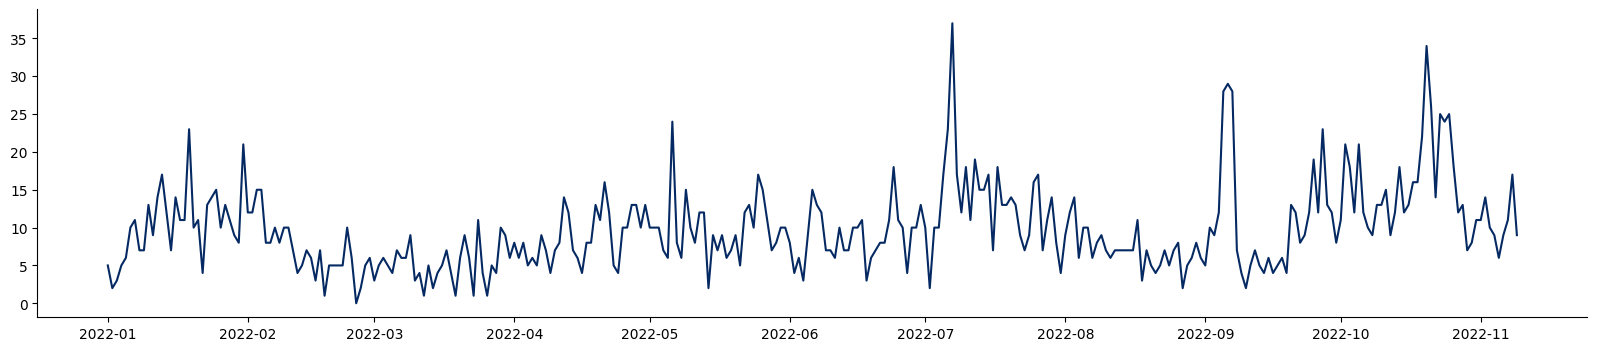

In [84]:
daily_counts = reindexed_data.resample('D').count()
plt.figure(figsize=[20,4])
plt.plot(daily_counts, linewidth = 1.5, color = '#052962')
sns.despine()
plt.show()

In [85]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''Function to get n-grams'''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)     
    vectorized_total = np.sum(vectorized_headlines, axis=0)     
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)     
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    
    
    for i in range(n_top_words):  
        word_vectors[i,word_indices[0,i]] = 1   

    words = [word[0].encode('ascii').decode('utf-8') for     
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])      

In [86]:
def n_grams_graph(ngram,year,n_words):
    '''Function to produce ngrams graph'''
    count_vectorizer = CountVectorizer(stop_words='english',ngram_range=(ngram,ngram))
    if year in range(2013,2023):
        words, word_values = get_top_n_words(n_top_words=n_words,
                                             count_vectorizer=count_vectorizer, 
                                             text_data=df.headline_clean[df['year'] == year])
    elif year=='all':
        words, word_values = get_top_n_words(n_top_words=n_words,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df.headline_clean)
    else:
        pass
        

    fig, ax = plt.subplots(figsize=(12,7))
    ax.barh(range(len(words)), word_values, color='#115DA8')
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words, rotation=0, fontsize = 9)
    plt.tick_params(axis='both', which='major', labelsize=9)
    if ngram== 1:
        ax.set_title(f'Top Unigrams in headlines in {year}', fontsize = 11)
    elif ngram== 2:
        ax.set_title(f'Top Bigrams in headlines in {year}', fontsize = 11)
    elif ngram == 3:
        ax.set_title(f'Top Trigrams in headlines in {year}', fontsize = 11)
    else:
        ax.set_title(f'Top words in headlines in {year}', fontsize = 11)

    ax.set_xlabel('Number of occurrences')
    ax.set_ylabel('Word', fontsize = 11)
    sns.despine()

    #plt.savefig(f'headlines{year}{ngram}.png', dpi=1300, transparent = True)
    plt.show()

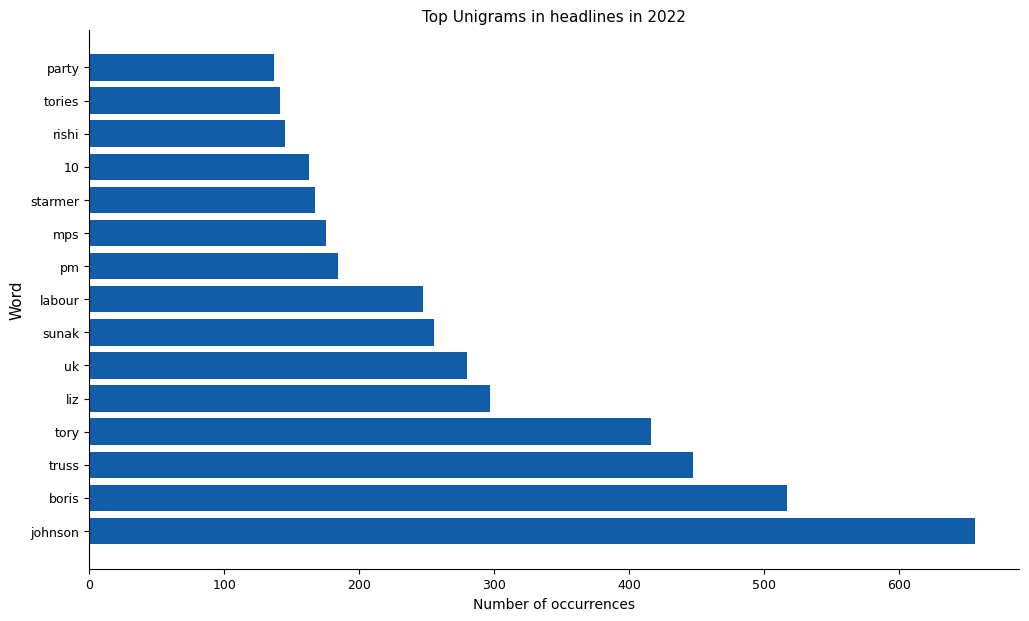

In [87]:
n_grams_graph(1,2022,15)

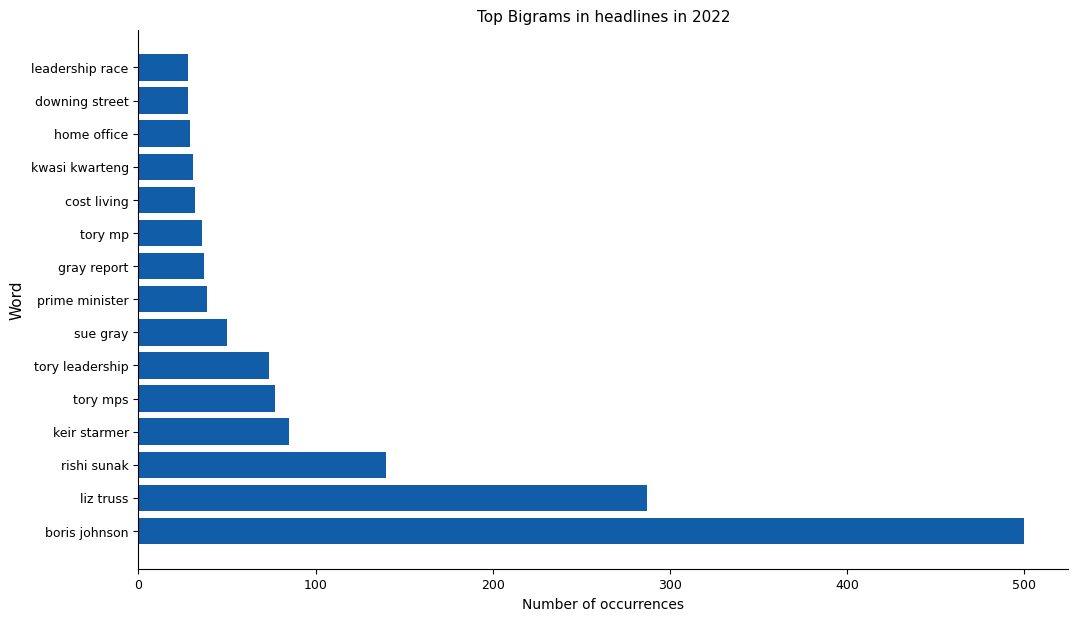

In [88]:
n_grams_graph(2,2022,15)

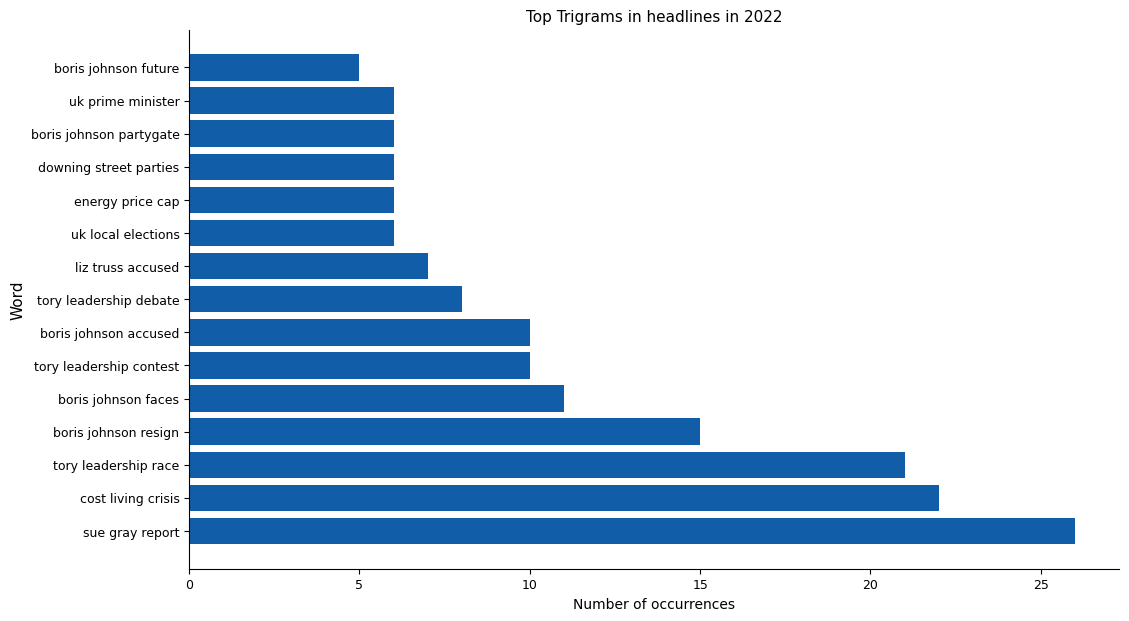

In [89]:
n_grams_graph(3,2022,15)

<br>

## <font color='#0084C6'>**2012-2022 Data**</font> 

In [90]:
reindexed_data = df['headline'].copy()
reindexed_data.index = df['date'].copy()

In [91]:
monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()

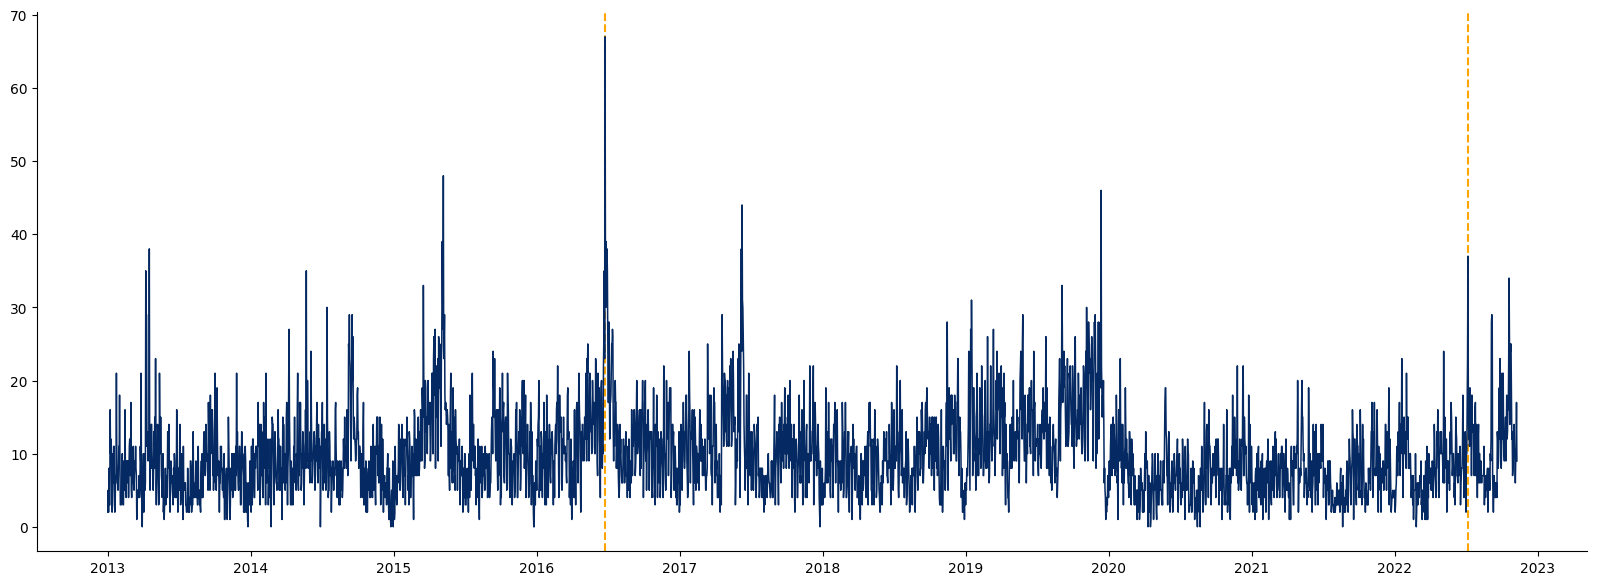

In [140]:
plt.figure(figsize=[20,7])

dates = [
    datetime.datetime(2022, 7, 7),
    datetime.datetime(2016, 6, 24)
]
for date in dates:
    plt.axvline(date, linestyle='--', linewidth=1.5, color='orange')

plt.plot(daily_counts, linewidth = 1.1, color = '#052962')


sns.despine()
plt.savefig('dailycounts2.png', dpi=1300, transparent = True)
plt.show()

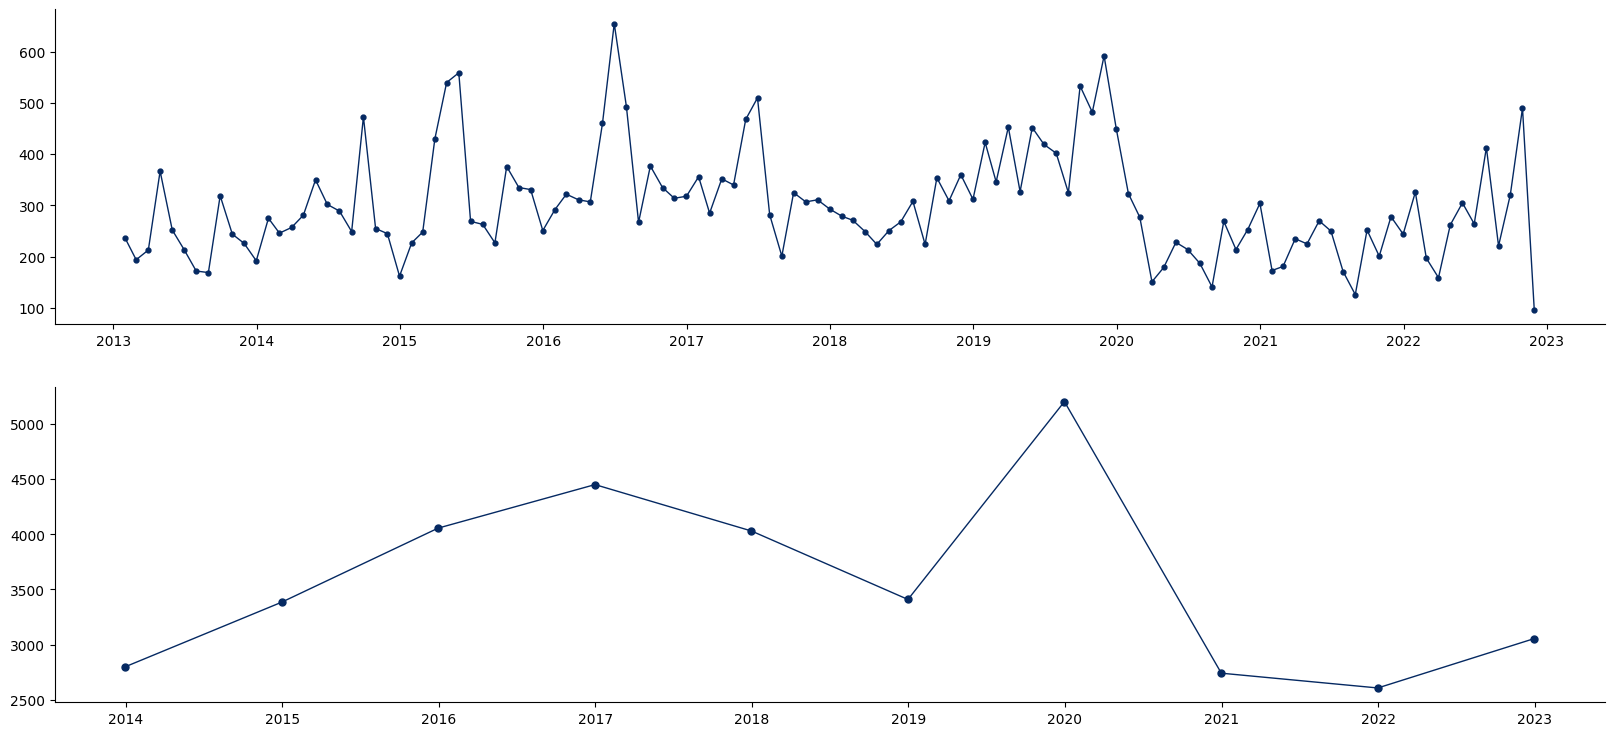

In [93]:
fig, ax = plt.subplots(2, figsize=(20,9))


# Remove the x-axis tick labels from subplot 2
ax[0].plot(monthly_counts,  marker='o', linewidth = 1, color = '#052962', markersize=3.5)


# Keep the x-axis tick labels for subplot 3
ax[1].plot(yearly_counts,  marker='o', linewidth = 1, color = '#052962', markersize=5)

# Adjust the plot layout and remove the spines
plt.subplots_adjust(wspace=1, hspace=0.2)
sns.despine()

# Show the plot
plt.show()


<br>

## <font color='#0084C6'>**The 7 Most Active Days**</font> 

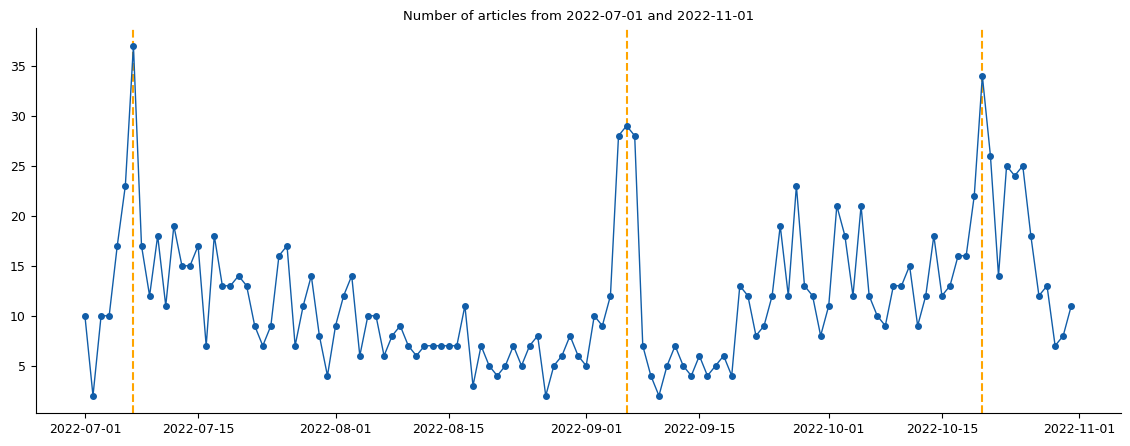

In [94]:
## 2022 disaster
start_date = pd.to_datetime('2022-07-01')
end_date = pd.to_datetime('2022-10-31')
s_filtered = daily_counts[(daily_counts.index >= start_date) & (daily_counts.index <= end_date)]

# Plot the filtered series
plt.figure(figsize=[14,5])

dates = [
    datetime.datetime(2022, 7, 7),
    datetime.datetime(2022, 10, 20),
    datetime.datetime(2022, 9, 6), 
]


for date in dates:
    plt.axvline(date, linestyle='--', linewidth=1.5, color='orange')

plt.plot(s_filtered.index, s_filtered, marker="o", markersize=4, linewidth=1, color='#115DA8' )
plt.tick_params(axis='both', which='major', labelsize=9)
plt.title('Number of articles from 2022-07-01 and 2022-11-01', fontsize = 9.5)

# Show the plot
sns.despine()
plt.savefig('2022noart.png', dpi=1300, transparent = True)
plt.show()

<br><br>

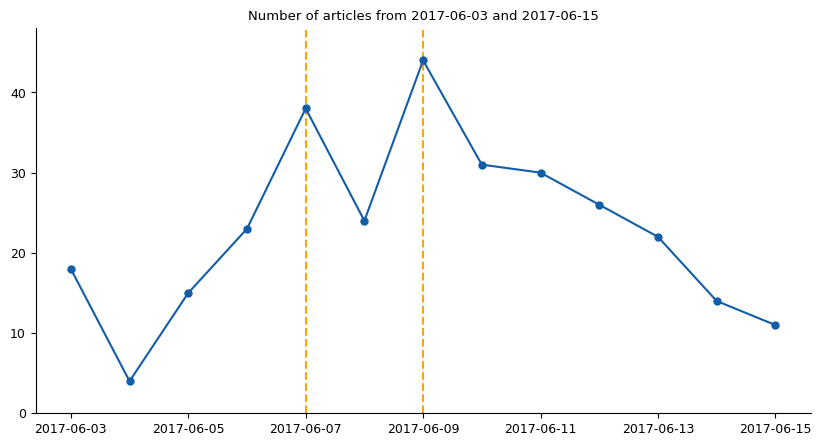

In [95]:
## theresa may's failed election
start_date = pd.to_datetime('2017-06-03')
end_date = pd.to_datetime('2017-06-15')
s_filtered = daily_counts[(daily_counts.index >= start_date) & (daily_counts.index <= end_date)]

# Plot the filtered series
plt.figure(figsize=[10,5])

dates = [
    datetime.datetime(2017, 6, 9),
    datetime.datetime(2017, 6, 7), 
]

for date in dates:
    plt.axvline(date, linestyle='--', linewidth=1.5, color='orange')

plt.plot(s_filtered.index, s_filtered, marker="o", markersize=5, linewidth=1.5, color='#115DA8' )
plt.tick_params(axis='both', which='major', labelsize=9)
plt.ylim(0, 48)
plt.title('Number of articles from 2017-06-03 and 2017-06-15', fontsize = 9.5)
# Show the plot
sns.despine()
plt.savefig('tmleave.png', dpi=1300, transparent = True)
plt.show()

<br><br>

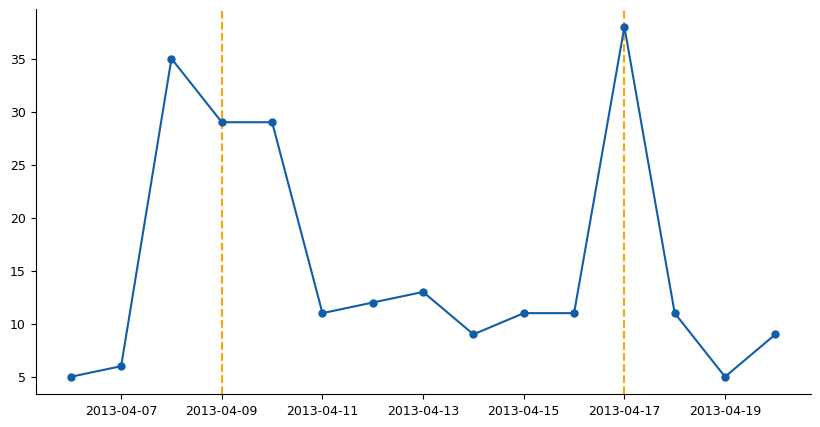

In [96]:
start_date = pd.to_datetime('2013-04-06')
end_date = pd.to_datetime('2013-04-20')
s_filtered = daily_counts[(daily_counts.index >= start_date) & (daily_counts.index <= end_date)]

# Plot the filtered series
plt.figure(figsize=[10,5])

dates = [
    datetime.datetime(2013, 4, 9),
    datetime.datetime(2013, 4, 17), 
]

for date in dates:
    plt.axvline(date, linestyle='--', linewidth=1.5, color='orange')

plt.plot(s_filtered.index, s_filtered, marker="o", markersize=5, linewidth=1.5, color='#115DA8')
plt.tick_params(axis='both', which='major', labelsize=9)
# Show the plot
sns.despine()
plt.show()

<br><br>

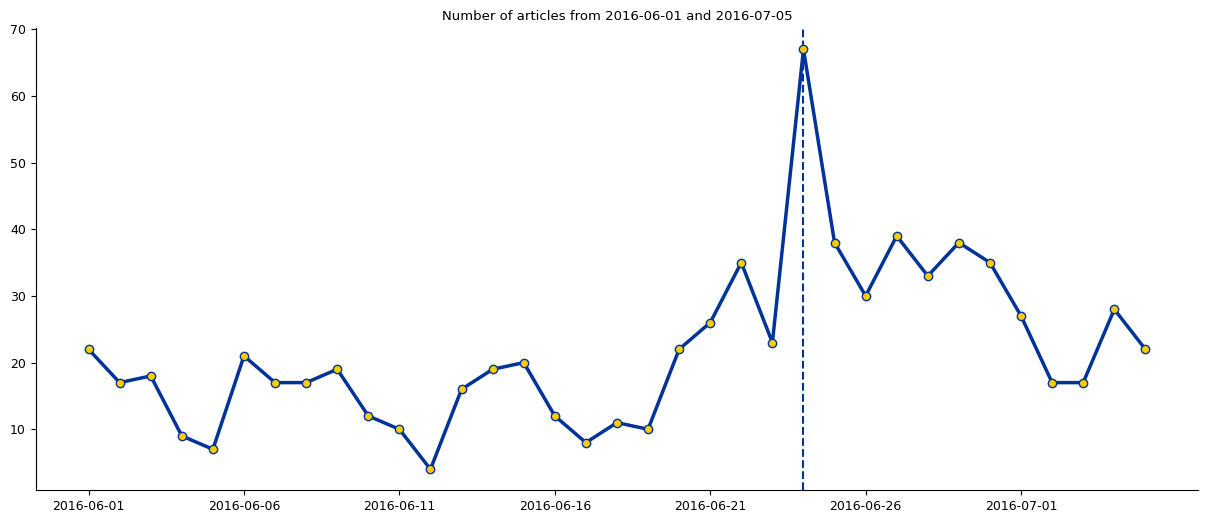

In [97]:
start_date = pd.to_datetime('2016-06-01')
end_date = pd.to_datetime('2016-07-05')
s_filtered = daily_counts[(daily_counts.index >= start_date) & (daily_counts.index <= end_date)]

# Create the plot
plt.figure(figsize=[15,6])
plt.axvline(datetime.datetime(2016, 6, 24), linestyle='--', linewidth=1.5, color='#003399')
plt.plot(s_filtered.index, s_filtered, marker="o", markersize=6, markerfacecolor='#FFCC00', markeredgecolor = '#003399', linewidth=2.5, color='#003399')

# Set the xticks to go up in 5 day intervals
plt.xticks(s_filtered.index[::5])

# Set the font size of the tick labels
plt.tick_params(axis='both', which='major', labelsize=9)

# Remove the top and right spines of the plot
sns.despine()
plt.title('Number of articles from 2016-06-01 and 2016-07-05', fontsize = 9.5)
plt.savefig('brexit.png', dpi=1300, transparent = True)

plt.show()


<br><br>

## <font color='#0084C6'>**N-grams**</font> 

In [98]:
## Key moments in british politics and look at aritcle count: 
## Key events: Brexit, 2015 2017 and 2019 election, Covid, Party Gate, Climate Change

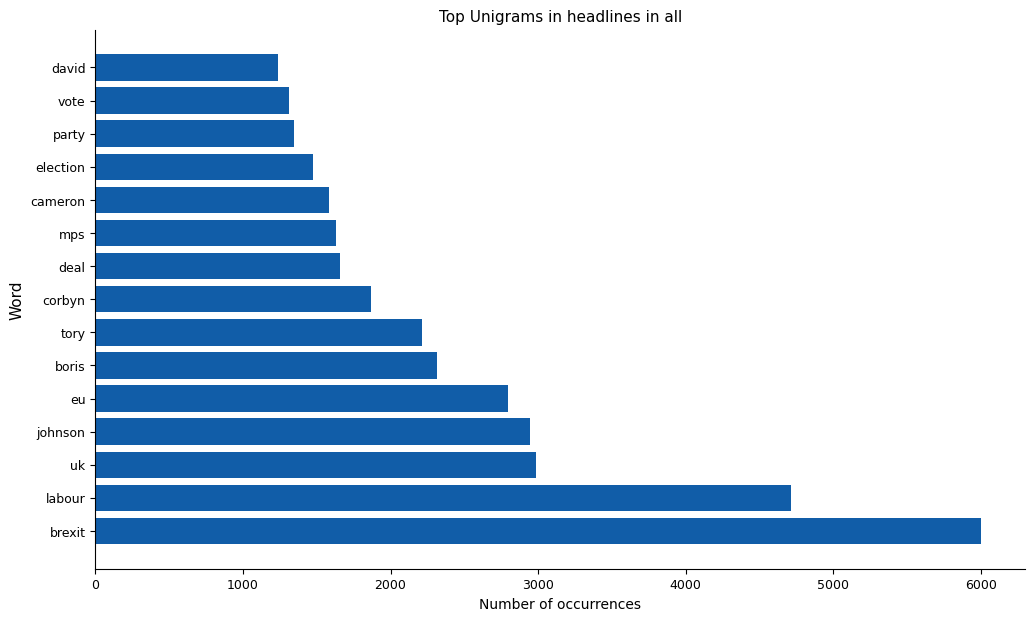

In [99]:
n_grams_graph(1,'all',15)

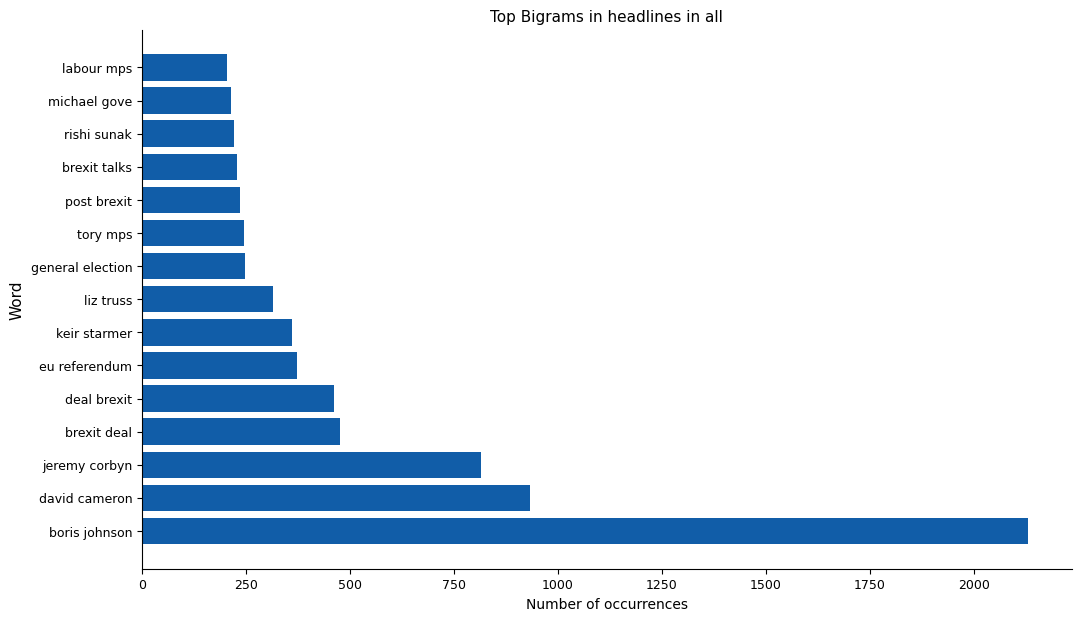

In [100]:
n_grams_graph(2,'all',15)

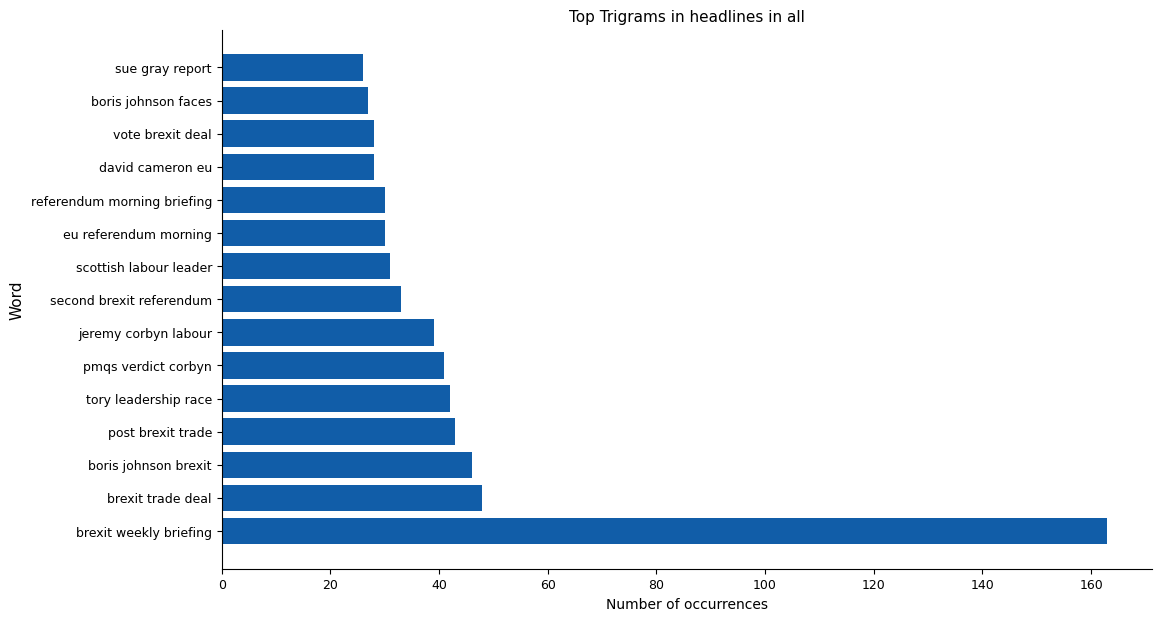

In [101]:
n_grams_graph(3,'all',15)

In [129]:
def n_grams_graph1(ngram,date,n_words):
    '''Function to produce ngrams graph'''
    count_vectorizer = CountVectorizer(stop_words='english',ngram_range=(ngram,ngram))

    words, word_values = get_top_n_words(n_top_words=n_words,
                                         count_vectorizer=count_vectorizer, 
                                         text_data=df.headline_clean[df['date'] == date])


    fig, ax = plt.subplots(figsize=(12,7))
    ax.barh(range(len(words)), word_values, color='#115DA8')
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words, rotation=0, fontsize = 9)
    plt.tick_params(axis='both', which='major', labelsize=9)
    if ngram== 1:
        ax.set_title(f'Top Unigrams in headlines on {date}', fontsize = 11)
    elif ngram== 2:
        ax.set_title(f'Top Bigrams in headlines on {date}', fontsize = 11)
    elif ngram == 3:
        ax.set_title(f'Top Trigrams in headlines on {date}', fontsize = 11)
    else:
        ax.set_title(f'Top words in headlines on {date}', fontsize = 11)

    ax.set_xlabel('Number of occurrences')
    ax.set_ylabel('Word', fontsize = 11)
    sns.despine()

    #plt.savefig(f'present{ngram}.png', dpi=1300, transparent = False)
    plt.show()

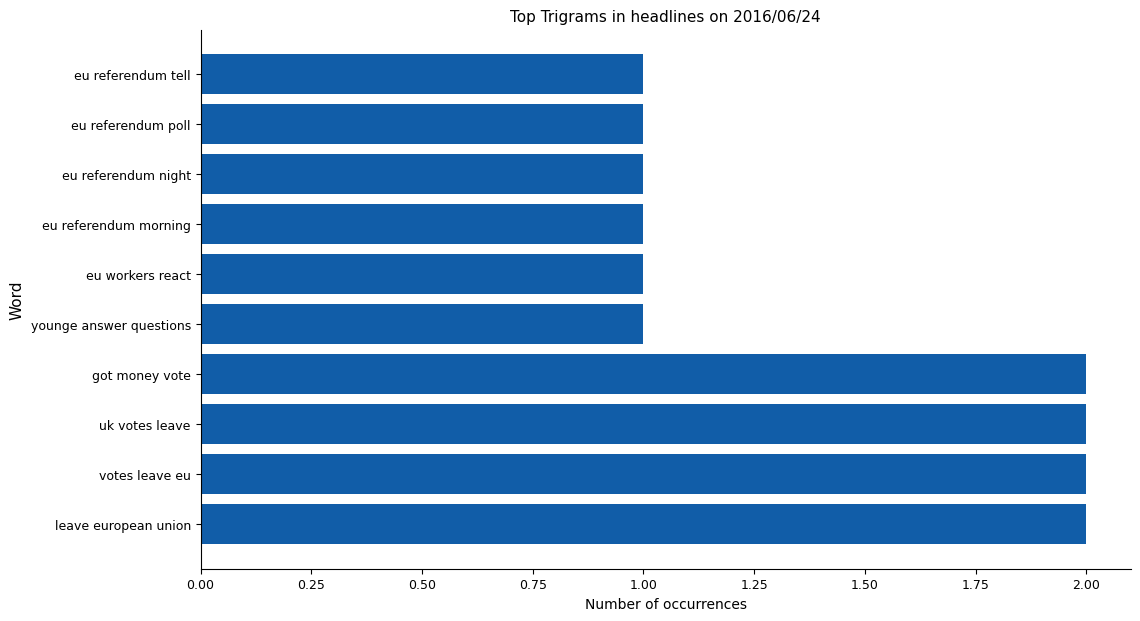

In [133]:
n_grams_graph1(3,'2016/06/24',10)

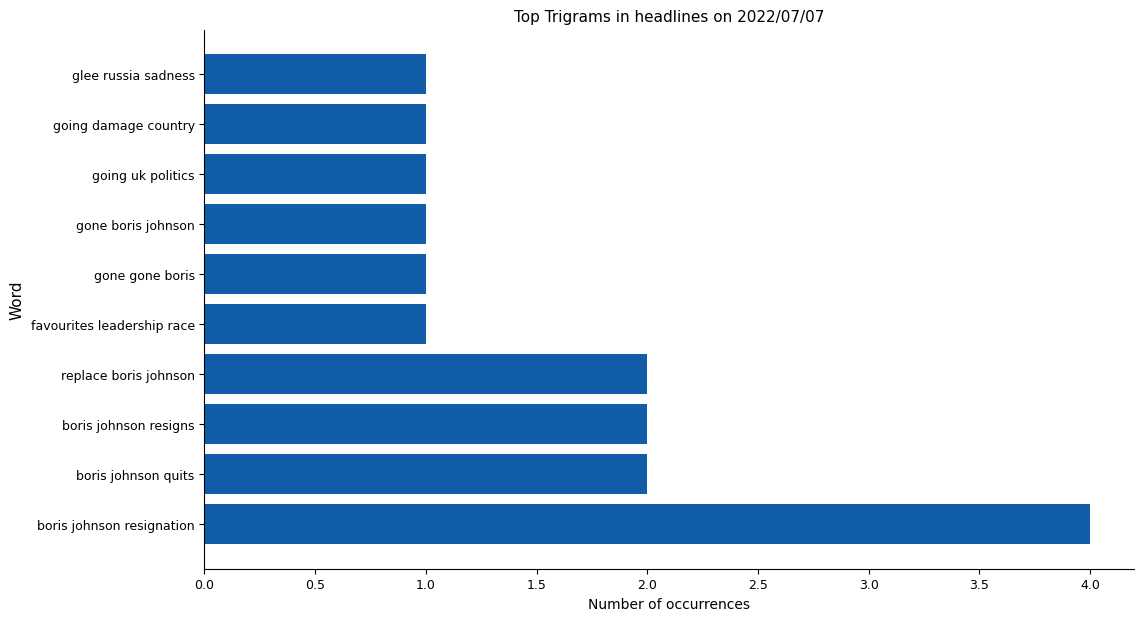

In [135]:
n_grams_graph1(3,'2022/07/07',10)

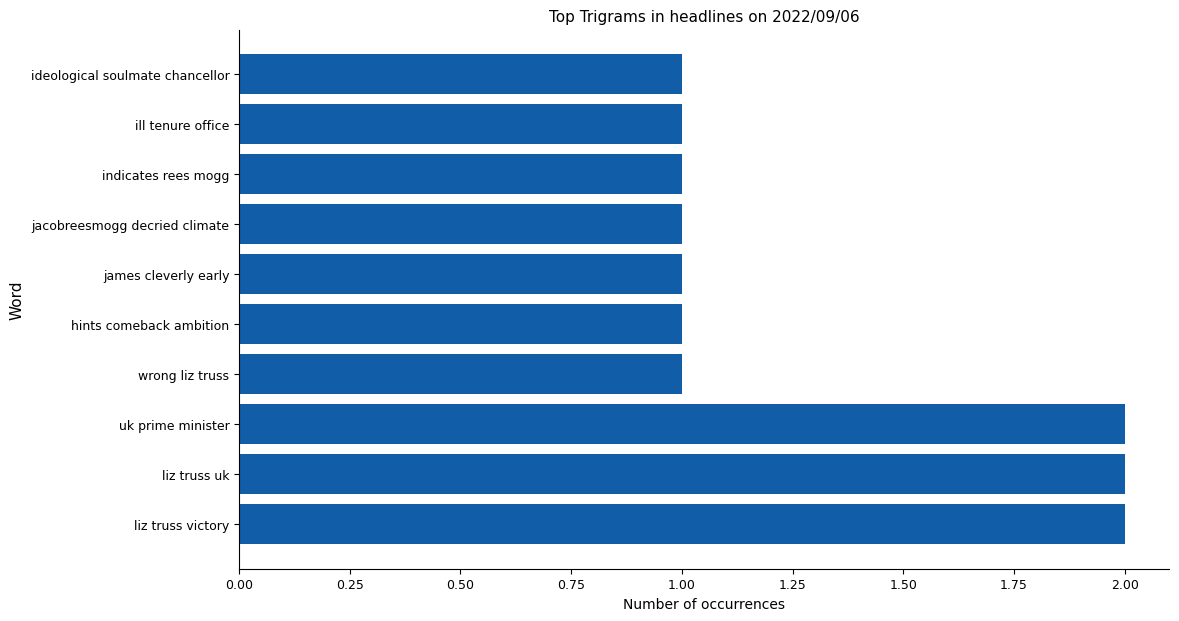

In [136]:
n_grams_graph1(3,'2022/09/06',10)

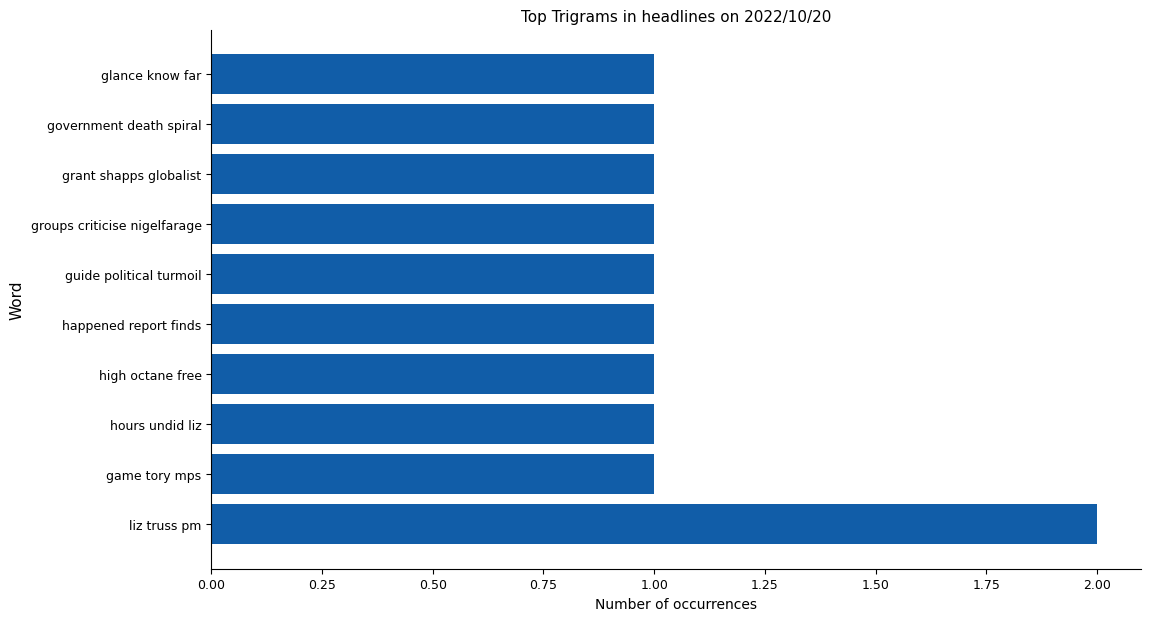

In [139]:
n_grams_graph1(3,'2022/10/20',10)

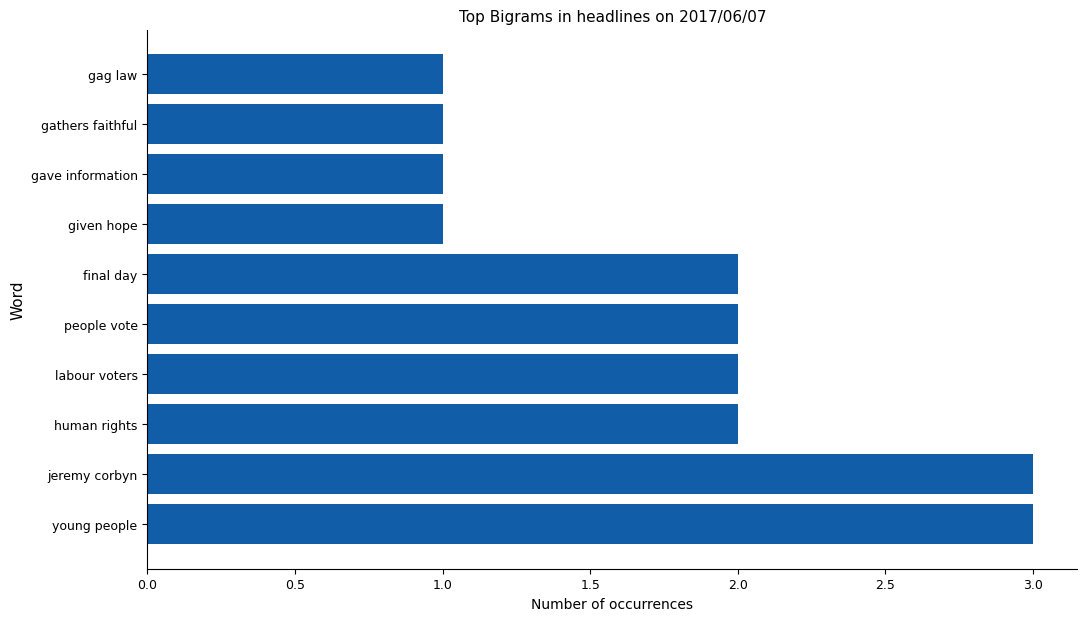

In [122]:
n_grams_graph1(2,'2017/06/07',10)

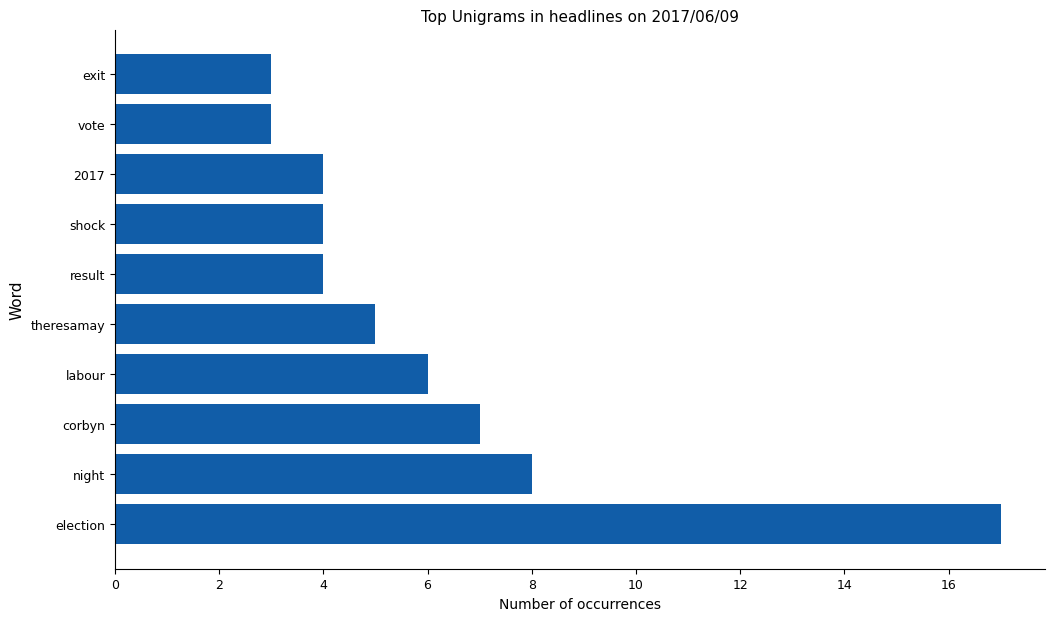

In [123]:
n_grams_graph1(1,'2017/06/09',10)

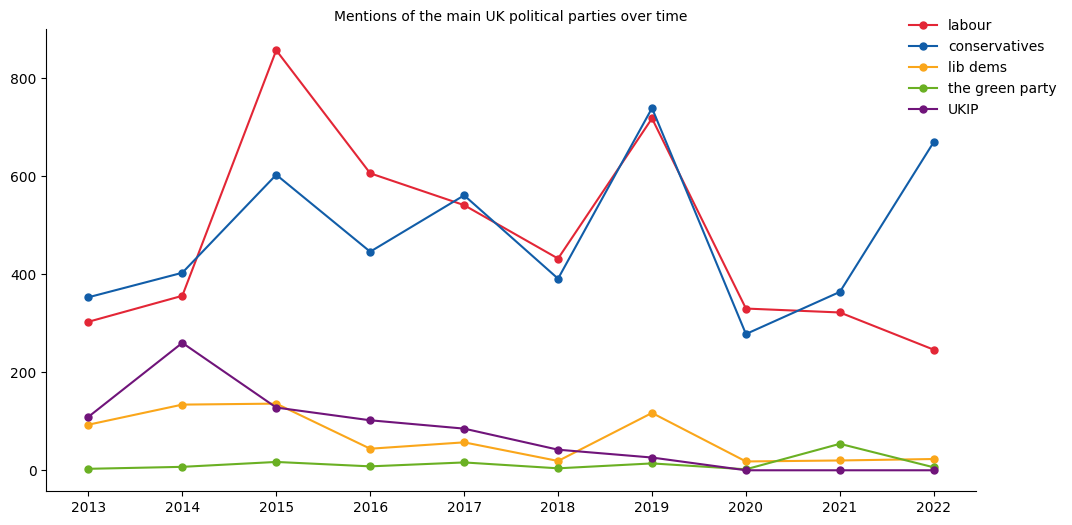

In [1686]:
partys = ["labour","conservative|tor", "libdem", "greens", "ukip"]
data = {}

for name in partys:
    index = df['headline'].str.contains(name)
    data[name] = pd.DataFrame(df['year'].loc[index].value_counts().sort_index())

pparty = pd.concat(data, axis=1)
pparty = pparty.fillna(0)

# create plot
ax = pparty.plot(figsize=(12,6), marker="o", markersize=5, linewidth=1.5, xticks = range(2013,2023), color=["#E32636", "#115DA8",'#FAA61A', '#6AB023', '#70147a'])

# change legend labels
ax.legend(labels=["labour", "conservatives", "lib dems", "the green party", "UKIP"], bbox_to_anchor=(1.1, 1.05), frameon = False)
plt.tick_params(axis='both', which='major', labelsize=10)
# add title
plt.title("Mentions of the main UK political parties over time", fontsize=10)

# remove spines
sns.despine()
#plt.savefig('partymentions.png', dpi=1300, transparent = True)
# show plot
plt.show()

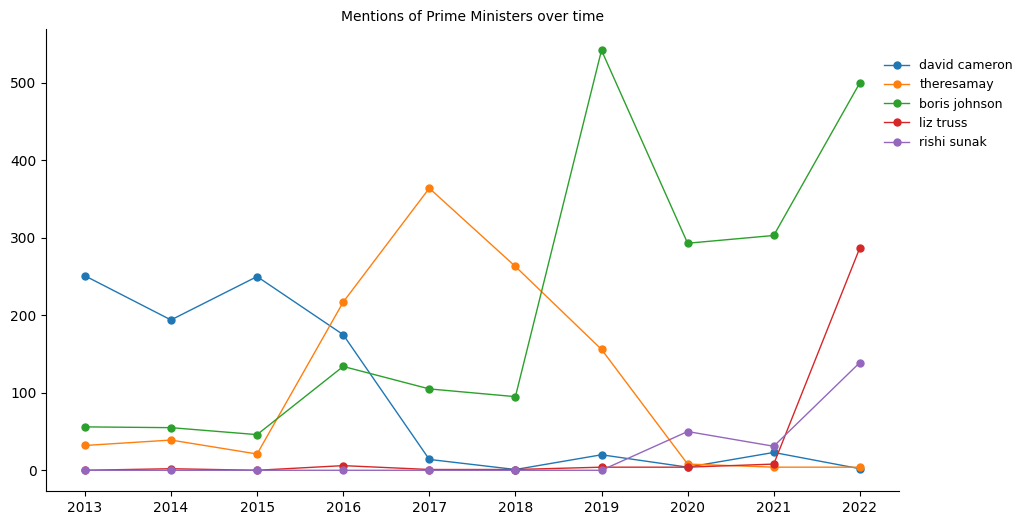

In [78]:
names = ["david cameron", "theresamay", "boris johnson", "liz truss", "rishi sunak"]
data = {}

for name in names:
    index = df['headline'].str.contains(name)
    data[name] = pd.DataFrame(df['year'].loc[index].value_counts().sort_index())

pms = pd.concat(data, axis=1)
pms.columns = names
pms = pms.fillna(0)

ax = pms.plot(figsize=(11,6), marker="o", markersize=5, linewidth=1, xticks = range(2013,2023))
ax.legend(bbox_to_anchor=(0.97, 0.96), frameon = False, fontsize = 9)
plt.title("Mentions of Prime Ministers over time", fontsize=10)
sns.despine()
plt.savefig('pmm.png', dpi=1300, transparent = False)
plt.show()

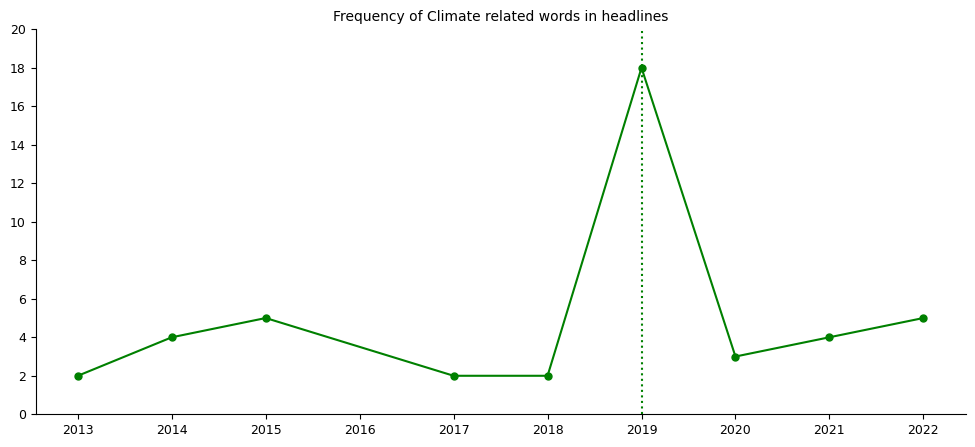

In [79]:
envir = ["climate change", "climate crisis", "global warming", "deforestation"]

# Create a single DataFrame containing the data for all names
index = df['headline'].str.contains('|'.join(envir))
climate = pd.DataFrame(df['year'].loc[index].value_counts().sort_index())
climate = climate.fillna(0)

ax = climate.plot(figsize=(12,5), marker="o", markersize=5, linewidth=1.5, legend = False, color='green', xticks = range(2013,2023),yticks=range(0, 21, 2))
plt.tick_params(axis='both', which='major', labelsize=9)
plt.axvline(x=2019, linestyle=':', color='green') 
plt.title("Frequency of Climate related words in headlines", fontsize=10)
sns.despine()
plt.savefig('cm.png', dpi=1300, transparent = False)
plt.show()

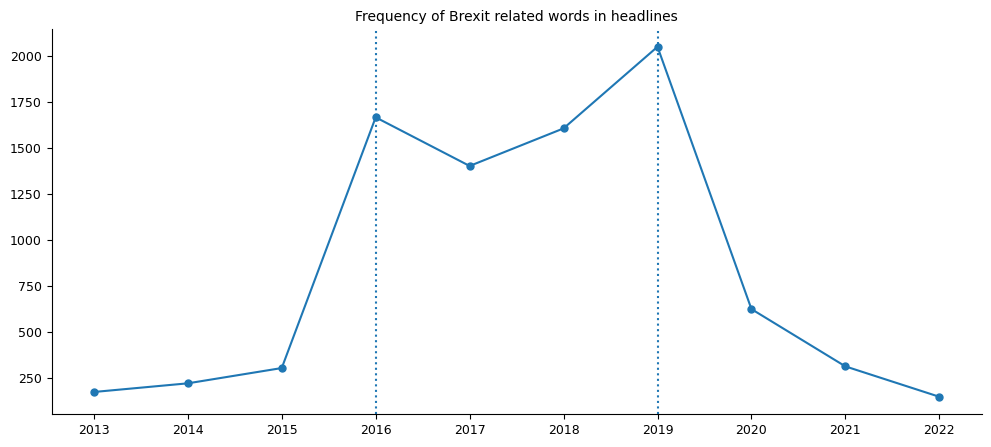

In [80]:
index = df['headline'].str.contains('brexit|eu')
brexit = pd.DataFrame(df['year'].loc[index].value_counts().sort_index())
brexit = brexit.fillna(0)

ax = brexit.plot(figsize=(12,5), marker="o", markersize=5, linewidth=1.5, legend = False, xticks= range(2013,2023))
plt.title("Frequency of Brexit related words in headlines", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.axvline(x=2016, linestyle=':') 
plt.axvline(x=2019, linestyle=':') 
sns.despine()
plt.savefig('bm.png', dpi=1300, transparent = False)
plt.show()

<br><br>

# <font color='#0084C6'>**Sentiment Analysis**</font>

In [1688]:
df_sent = df.copy()

In [1689]:
sia = SIA()
def vader_sim(txt):
    pol_score = sia.polarity_scores(txt)
    return pol_score['compound']

In [1690]:
df_sent['vader_pol'] = df_sent['headline_clean'].apply(vader_sim)

In [1691]:
def blob_sent(txt):
    txt = TextBlob(txt)
    sent_score = txt.sentiment.polarity
    return sent_score

In [1692]:
df_sent['blob_sent'] = df_sent['headline_clean'].apply(blob_sent)

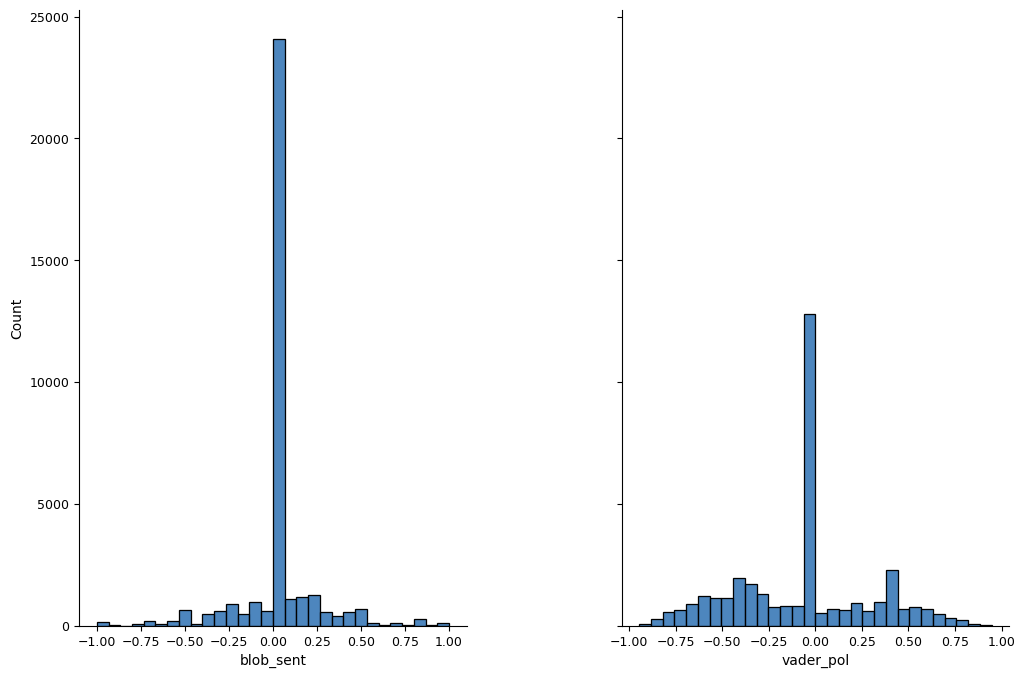

In [1693]:
# Create a figure with two subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12, 8], sharey = True)

# Use seaborn's histplot function to plot the histogram on the first subplot
sns.histplot(data=df_sent, x='blob_sent', bins=30, color='#115DA8', ax=ax[0])
ax[0].tick_params(axis='both', which='major', labelsize=9)
sns.despine(ax=ax[0])

# Use seaborn's histplot function to plot the histogram on the second subplot
sns.histplot(data=df_sent, x='vader_pol', bins=30, color='#115DA8', ax=ax[1])
ax[1].tick_params(axis='both', which='major', labelsize=9)
ax[1].set_ylabel('')
plt.subplots_adjust(wspace=0.4)
sns.despine(ax=ax[1])
plt.savefig('polarity.png', dpi=1300, transparent = True)
plt.show()


In [1833]:
n = 10

random_answers = df_sent.sample(n=n) # selecting nulls
random_answers.reset_index(inplace=True, drop=True)

for i in range(0, n):
    print(random_answers['headline'].iloc[i])
    print(random_answers['blob_sent'].iloc[i])
    print(random_answers['vader_pol'].iloc[i])
    print('\n')

equality watchdog attacks boris johnson 'inflammatory' remarks
0.0
-0.4404


a new prime minister is forced upon us
-0.08181818181818185
-0.4588


cameron vows to rule uk as 'one nation' but scottish question looms
0.0
-0.1531


uk draft eu document wins muted european support
0.15
0.7506


many eu citizens will be unable to vote in uk, campaigners warn
0.0
-0.1027


'betrayed': dover residents furious over building of brexit lorry park
0.0
-0.8271


pm scrapes barrel with prisons joke
0.0
0.296


david cameron tax affairs should be no private matter
0.0
0.0258


rachel reeves offers serious relief from tories’ unhinged trussonomics
-0.11666666666666665
0.4215


how accurate were johnson andrew marr interview claims?
0.4000000000000001
0.0




<br><br><br>

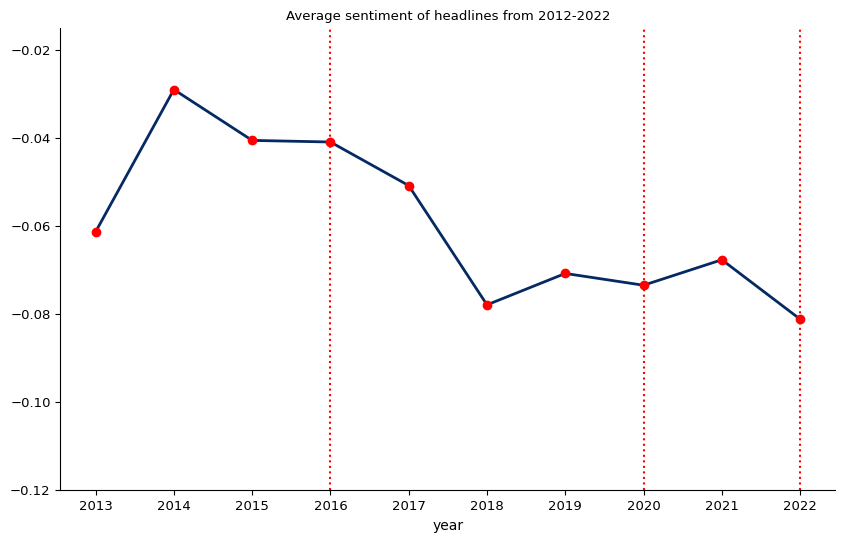

In [1696]:
## 2012-2022 Average
df_sent[['year','vader_pol']].groupby('year').mean().plot(marker='o', linewidth = 2, color = '#052962', markersize=6, markerfacecolor='red', markeredgecolor = 'red', legend=False,xticks = range(2013,2023), figsize=[10,6])
plt.ylim(-0.12, -0.015)
plt.tick_params(axis='both', which='major', labelsize=9.5)
plt.title('Average sentiment of headlines from 2012-2022', fontsize =9.5)
for year in [2016,2020,2022]:
    plt.axvline(x=year, linestyle=':', color='red') 
sns.despine()
plt.savefig('allsentiment.png', dpi=1300, transparent = True)
plt.show()

In [1697]:
df22['vader_pol'] = df22['headline_clean'].apply(vader_sim)
df22['month'] = pd.DatetimeIndex(df22['date']).month

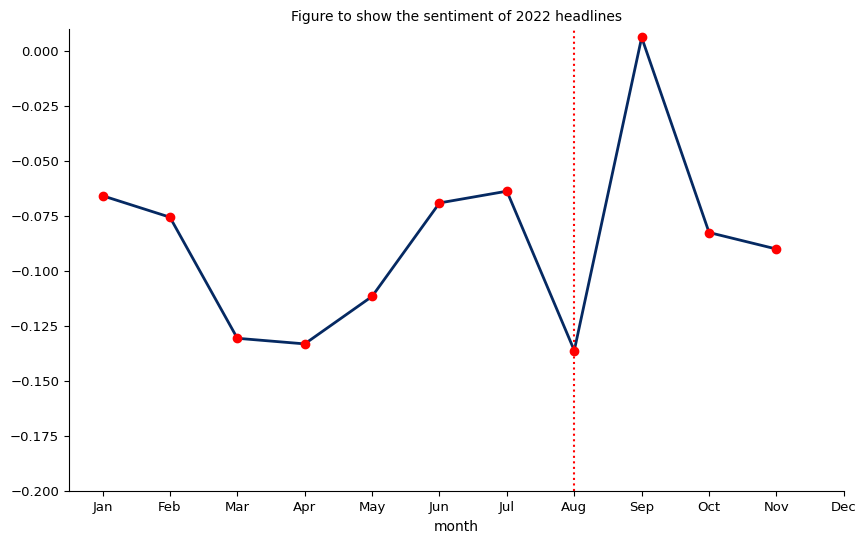

In [1740]:
# Define the dataframe and group it by month
df22[['month','vader_pol']].groupby('month').mean().plot(marker='o', linewidth = 2, color = '#052962', markersize=6, markerfacecolor='red', markeredgecolor = 'red', legend=False, figsize=[10,6])

# Set the y-axis limits
plt.ylim(-0.2, 0.01)

# Remove the spines
sns.despine()
plt.axvline(x=8, linestyle=':', color='red') 
# Set the x-axis tick labels to the names of the months
plt.xticks(range(1,13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tick_params(axis='both', which='major', labelsize=9.5)

plt.title('Figure to show the sentiment of 2022 headlines', fontsize = 10)
#plt.savefig('2022sentiment.png', dpi=1300, transparent = True)

plt.show()

<br><br><br>

In [1700]:
## Sentiment on people and key policies

In [1701]:
index_tory=df_sent['headline_clean'].str.match(r'tori|tories|conservative')
tory= df_sent.loc[index_tory].copy()

In [1702]:
index_lab=df_sent['headline_clean'].str.match(r'labour')
lab= df_sent.loc[index_lab].copy()

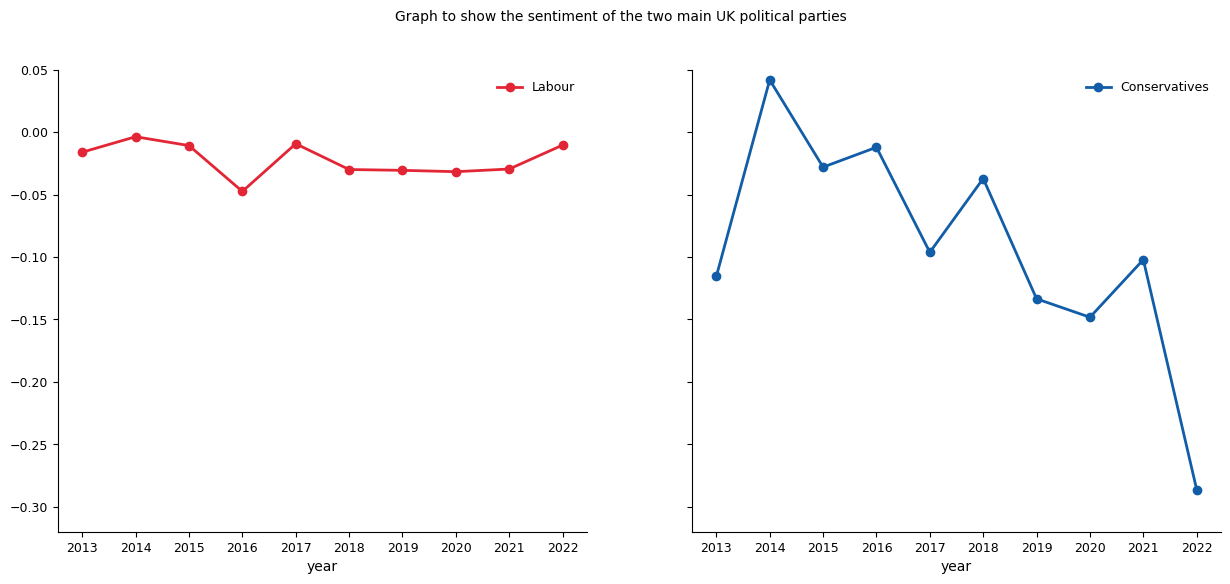

In [1705]:
# create a figure and set of subplots
fig, axes = plt.subplots(1, 2, sharey = True, figsize = [15,6])

# plot the first data on the first subplot
lab[['year','vader_pol']].groupby('year').mean().plot(
    ax=axes[0],
    marker='o',
    linewidth = 2,
    color = '#E32636',
    markersize=6,
    markerfacecolor='#E32636',
    markeredgecolor = '#E32636',
    legend=False,
    xticks = range(2013,2023)
)
axes[0].legend(['Labour'], fontsize=9, frameon = False)

# plot the second data on the second subplot
tory[['year','vader_pol']].groupby('year').mean().plot(
    ax=axes[1],
    marker='o',
    linewidth = 2,
    color = '#115DA8',
    markersize=6,
    markerfacecolor='#115DA8',
    markeredgecolor = '#115DA8',
    legend=False,
    xticks = range(2013,2023)
)

axes[1].legend(['Conservatives'], fontsize=9,frameon = False)

axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=9)
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=9)
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=9)

# set the y-axis limit for both subplots
plt.ylim(-0.32, 0.05)

# add a title to the entire figure
fig.suptitle('Graph to show the sentiment of the two main UK political parties', fontsize=10)

# remove the spines (i.e., the borders) from the plots
sns.despine()
#plt.savefig('labtorysent.png', dpi=1300, transparent = True)
# show the figure
plt.show()


In [1706]:
index_pm=df_sent['headline_clean'].str.match(r'prime minist')
prime_m= df_sent.loc[index_pm].copy()

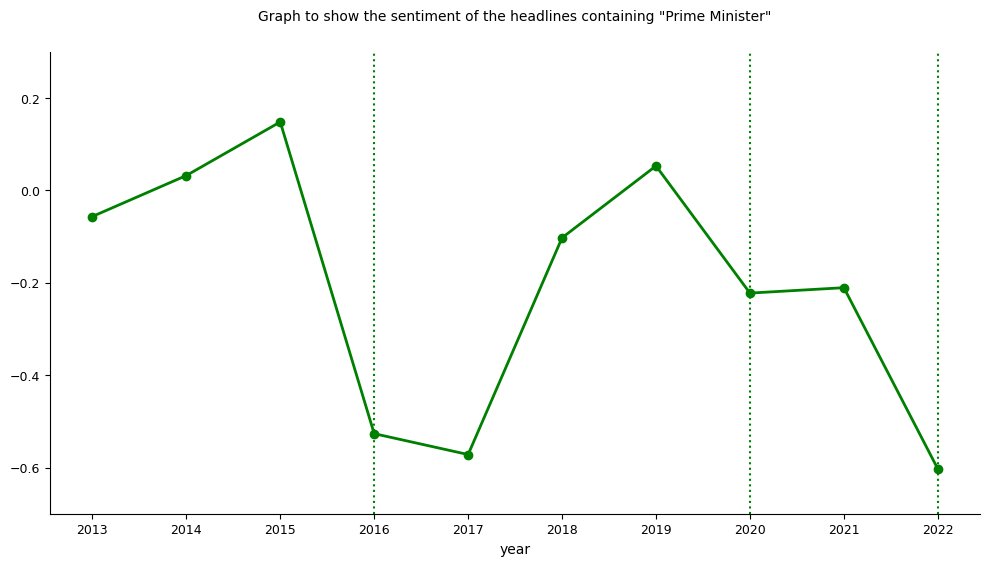

In [1708]:
prime_m[['year','vader_pol']].groupby('year').mean().plot(
    marker='o', 
    linewidth = 2, 
    color = 'green', 
    markersize=6, 
    markerfacecolor='green', 
    markeredgecolor = 'green', 
    legend=False,
    xticks = range(2013,2023),
    figsize=[12,6])

plt.tick_params(axis='both', which='major', labelsize=9)
plt.ylim(-0.7, 0.3)
plt.title('Graph to show the sentiment of the headlines containing "Prime Minister"', fontsize=10, y=1.05)

for year in [2016,2020,2022]:
    plt.axvline(x=year, linestyle=':', color='green') 

sns.despine()
plt.savefig('pmsent.png', dpi=1300, transparent = True)
plt.show()

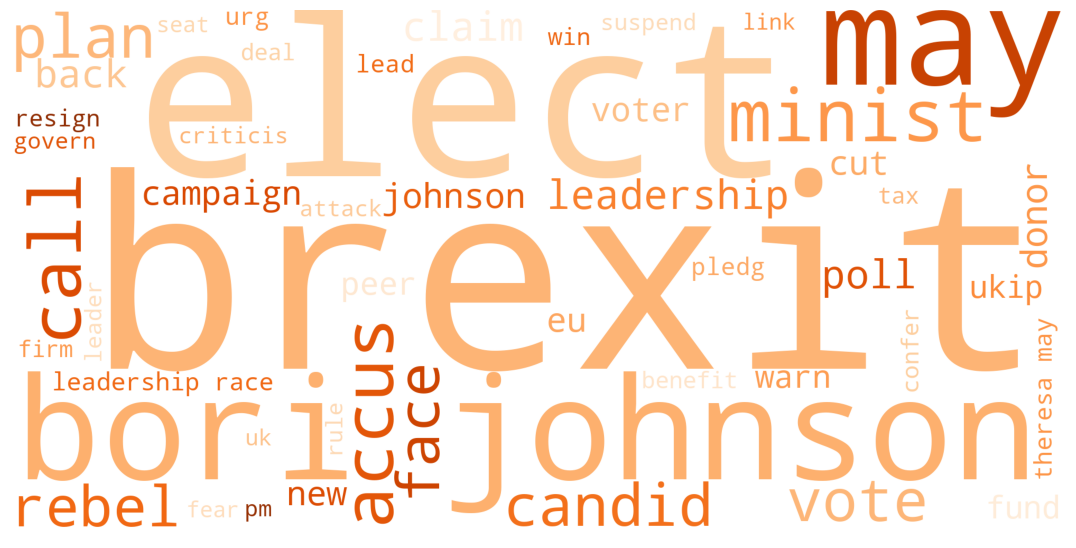

In [1709]:
labwc=" ".join(lab['headline_clean'].tolist())
labwc = re.sub(r"\blabour|parti|\bmp|\bs\b", "", tester, flags=re.IGNORECASE)


wc = WordCloud(max_words=50,width=2000,height=1000,background_color="white", colormap = 'Oranges_r').generate(labwc)

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(1,2,1)
ax.imshow(wc)
ax.axis('off')
plt.savefig('labwc.png', dpi=1300, transparent = True)
plt.show()

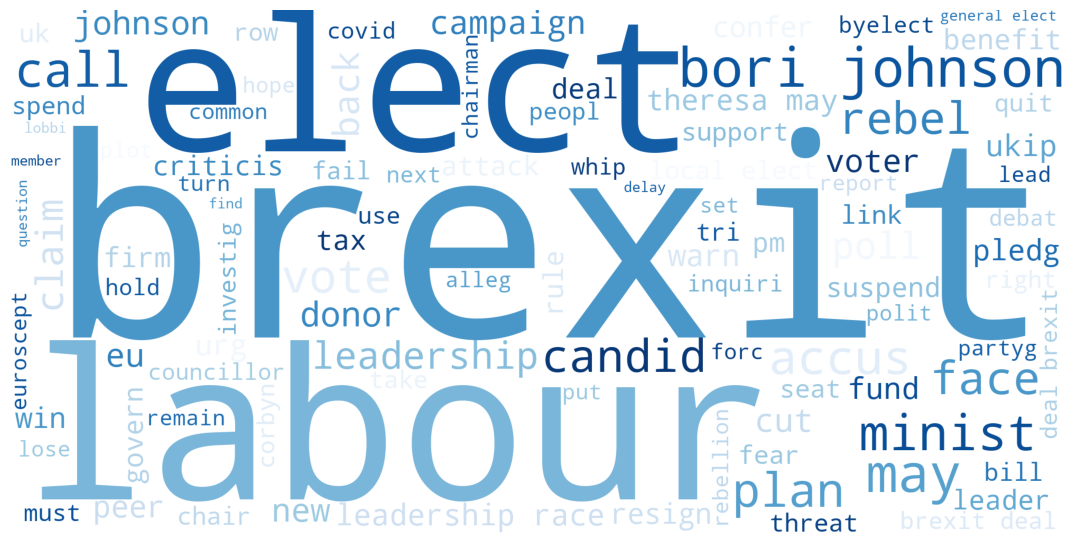

In [1710]:
torywc=" ".join(tory['headline_clean'].tolist())
torywc = re.sub(r"\btori\b|parti|\bmp|\bs\b", "", tester, flags=re.IGNORECASE)


wc = WordCloud(max_words=100,width=2000,height=1000,background_color="white", colormap = 'Blues').generate(torywc)

fig=plt.figure(figsize=(30,15))
ax=fig.add_subplot(1,2,1)
ax.imshow(wc)
ax.axis('off')
plt.savefig('torywc.png', dpi=1300, transparent = True)
plt.show()

**NLP frustrations**
- **Entities** hold sentiment like names 
- **Syntax**, where patterns such as headers or punctatuion cause inconsistencies 
- **Semnatic**, where typically positive words are used to expand negativity i.e, it is a great shame
- **Negation**, words like 'not' give negative score
- **Domain-Specific words and n-grams**: i.e people claiming benefits rise -> 'benefits' a negative context, classifed as postive?
- **Objective Statements** -> common in a broadsheet newspaper, most likely returned as neutral?